<h2> Importing libaries </h2>

In [1]:
import requests
from No_sync.credentials import config 
import requests
from pprint import pprint
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

<h2> Handling API requests and data extraction</h2>

In [2]:
# Get an access token from the API
def get_token():

  if not config['client_id']:
    raise ValueError('client_id must be set in credentials.py')

  if not config['client_secret']:
    raise ValueError('client_secret must be set in credentials.py')

  req = requests.post(config['token_url'],
    data={
        'grant_type': 'client_credentials',
        'client_id': config['client_id'],
        'client_secret': config['client_secret'],
        'scope': 'api'
    },
    headers={'content-type': 'application/x-www-form-urlencoded'})

  req.raise_for_status()
  print('Token request successful')
  return req.json()

In [3]:
# Get the weekly summary for a given year and week
def get_week_summary(token, year, week):

  url = f"{config['api_base_url']}/v1/geodata/fishhealth/locality/{year}/{week}"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()

In [4]:
# Make a sample request to the API
def make_sample_request(token):

  url = f"{config['api_base_url']}/v1/sample/auth"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()


In [5]:
# Request a token
print(f"Requesting token from {config['token_url']}, using client_id {config['client_id']}.")
token = get_token()

Requesting token from https://id.barentswatch.no/connect/token, using client_id dinussen.sivarasalingam@nmbu.no:Fishdata.
Token request successful


In [6]:
# Test token
response = make_sample_request(token)
print('Request to the api was successful - authentication worked.')
pprint(response)

Request to the api was successful - authentication worked.
{'id': 217723425,
 'name': 'https://www.barentswatch.no',
 'updated': '2023-10-24T17:41:39.2736283+02:00'}


<h2> Data transformation </h2>

In [7]:
def weeks_of_the_year():
    """
    Create a DataFrame with the week number and year for each week of the year
    """
    # Get the current year and the week of the year
    today = datetime.now()
    year = today.year
    day_of_year = today.strftime('%j')
    week_of_year = (int(day_of_year) - 1) // 7 + 1
    
    # Calculate the number of weeks left in the previous year
    weeks_left_last_year = 52 - week_of_year
    
    # Create DataFrames for the current year and the remaining weeks from the previous year
    week_df = pd.DataFrame({'Week': range(1, week_of_year + 1), 'Year': [year] * week_of_year})
    week_df_last = pd.DataFrame({'Week': range(1, weeks_left_last_year + 1), 'Year': [year - 1] * weeks_left_last_year})

    # Concatenate the two DataFrames
    week_df = pd.concat([week_df_last, week_df], ignore_index=True)
    # add week_of_year to week where year is current year - 1
    week_df.loc[week_df['Year'] == year - 1, 'Week'] += week_of_year

    return week_df

<h3> Getting year worth of data </h3>

In [8]:
def make_df(weeksummary):
    """
    Create a DataFrame from the week summary
    """
    df_data = pd.DataFrame()

    if 'localities' in weeksummary:
        localities = weeksummary['localities']

        if localities:
            # Extract common information
            common_info = {
                'year': weeksummary['year'],
                'week': weeksummary['week']
            }

            # Extract and flatten the localities data into a list of dictionaries
            data_list = []
            for information in localities:
                data = {**common_info, **information}
                data_list.append(data)

            # Create the DataFrame directly from the list of dictionaries
            df_data = pd.DataFrame(data_list)

    return df_data

In [9]:
def get_year_data(weeks_df):
    """
    This function returns a dataframe with all the data from the weeks in weeks_df
    """
    teller = 0
    df_data = pd.DataFrame()
    for week, year in weeks_df.values:
        teller +=1
        #print(week, year)
        weeksummary= get_week_summary(token,year,week)
        #print(weeksummary)
        df_to_concat = make_df(weeksummary)
        #print(df_to_concat)
        frames = [df_data, df_to_concat]
        df_data = pd.concat(frames, ignore_index=True)
        #print(teller)
    return df_data

In [10]:
# run the functions
weeks_df = weeks_of_the_year()
summary_oneyear = get_year_data(weeks_df)
summary_oneyear.shape

(89863, 21)

In [11]:
# add date column
summary_oneyear['date'] = pd.to_datetime(summary_oneyear['year'].astype(str) + '-W' + summary_oneyear['week'].astype(str) + '-1', format='%Y-W%U-%w')

In [12]:
# Convert all column names to lower case
summary_oneyear.columns = summary_oneyear.columns.str.lower()

In [13]:
# Save df as csv
summary_oneyear.to_csv('Data/summary_oneyear.csv', index=False)

In [14]:
# check nan values
summary_oneyear.isna().sum()

year                          0
week                          0
localityno                    0
localityweekid                0
name                          0
hasreportedlice               0
isfallow                      0
avgadultfemalelice        61008
hascleanerfishdeployed        0
hasmechanicalremoval          0
hassubstancetreatments        0
haspd                         0
hasila                        0
municipalityno                0
municipality                  0
lat                           0
lon                           0
isonland                      0
infilteredselection           0
hassalmonoids                 0
isslaughterholdingcage        0
date                          0
dtype: int64

<h3> Get lice count from one locality </h3>

In [15]:
def get_detailed_week(token, year, week, localityId):
  """
  Get the weekly summary for a given year and week
  """
  url = f"{config['api_base_url']}/v1/geodata/fishhealth/locality/{localityId}/{year}/{week}"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()

In [16]:
def extract_columns_from_json(json_data, desired_columns=['avgAdultFemaleLice', 'avgMobileLice', 'avgStationaryLice', 'localityName', 'speciesList']):
    """
    Extract specified columns from a JSON input and create a DataFrame.

    :param json_data: JSON data as a dictionary.
    :param desired_columns: List of column names to extract.
    :return: A DataFrame containing the extracted columns.
    """
    # Extract columns from 'localityWeek' if they exist
    locality_week_data = json_data.get('localityWeek', {})
    locality_week_columns = {col: locality_week_data.get(col) for col in ['avgAdultFemaleLice', 'avgMobileLice', 'avgStationaryLice']}
    
    # Extract 'speciesList' from 'aquaCultureRegister' if it exists
    aqua_culture_register_data = json_data.get('aquaCultureRegister', {})
    species_list = aqua_culture_register_data.get('speciesList')

    # Combine the extracted columns into a single dictionary
    filtered_data = {
        'avgAdultFemaleLice': locality_week_columns.get('avgAdultFemaleLice'),
        'avgMobileLice': locality_week_columns.get('avgMobileLice'),
        'avgStationaryLice': locality_week_columns.get('avgStationaryLice'),
        'localityName': json_data.get('localityName'),
        'speciesList': species_list
    }

    # Convert the dictionary into a DataFrame
    df = pd.DataFrame([filtered_data])
    
    return df


In [17]:
def get_lice_counts(token, weeks_df, locality=32277):
    """
    Get the lice counts for a given locality and a list of weeks.
    """

    lice_counts = pd.DataFrame()
    for week, year in weeks_df.values:
        weekdetails = get_detailed_week(token, year, week, locality)

        # Extract the desired columns from the JSON data
        df = extract_columns_from_json(weekdetails)

        # Create a new column combining "year" and "week" as a string
        df['year_week'] = f"{year}-{week}"

        # Convert the "year_week" column to datetime format
        df['year_week'] = pd.to_datetime(df['year_week'] + '-1', format='%Y-%U-%w')

        # Keep the original "week" and "year" columns
        df['week'] = week
        df['year'] = year

        # Concatenate the DataFrames
        lice_counts = pd.concat([lice_counts, df], ignore_index=True)
    return lice_counts

In [18]:
# Run the functions
lice_counts = get_lice_counts(token, weeks_df)

In [19]:
# Convert all column names to lower case
lice_counts.columns = lice_counts.columns.str.lower()

In [20]:
# Make df to csv
lice_counts.to_csv('Data/lice_counts.csv', index=False)

In [21]:
# Check nan values
lice_counts.isna().sum()

avgadultfemalelice    0
avgmobilelice         0
avgstationarylice     0
localityname          0
specieslist           0
year_week             0
week                  0
year                  0
dtype: int64

<h2> Connecting to Cassandra cluster and data loading</h2>

In [22]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [23]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [24]:
# set keyspace
session.set_keyspace('fish_keyspace')

<h4> Table for summary data </h4>

In [25]:
# Drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.fish_table_year;") 

# Create a new table
session.execute("""
   CREATE TABLE IF NOT EXISTS fish_table_year (
    localityno INT,
    localityweekid INT PRIMARY KEY,
    name TEXT,
    hasreportedlice BOOLEAN,
    isfallow BOOLEAN,
    avgadultfemalelice DOUBLE,
    hascleanerfishdeployed BOOLEAN,
    hasmechanicalremoval BOOLEAN,
    hassubstancetreatments BOOLEAN,
    haspd BOOLEAN,
    hasila BOOLEAN,
    municipalityno INT,
    municipality TEXT,
    lat DOUBLE,
    lon DOUBLE,
    isonland BOOLEAN,
    infilteredselection BOOLEAN,
    hassalmonoids BOOLEAN,
    isslaughterholdingcage BOOLEAN,
    year INT,
    week INT,
    date DATE
);
""")


<h4> Table for lice data </h4>

In [26]:
# Drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.lice_count_table;") 

# Create a new table
session.execute("""
    CREATE TABLE IF NOT EXISTS lice_count_table (
        avgadultfemalelice DOUBLE,
        avgmobilelice DOUBLE,
        avgstationarylice DOUBLE,
        localityname TEXT,
        specieslist TEXT,
        year_week DATE,
        week INT,
        year INT,
        total_lice DOUBLE,
        avgadultfemalelice_prop DOUBLE,
        avgmobilelice_prop DOUBLE,
        avgstationarylice_prop DOUBLE,
        PRIMARY KEY (year_week)
    );
""")

<h4> Connecting to cluster </h4>

In [27]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [28]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

<h4>Write data to db</h4>

In [29]:
# Read the data from the csv files
year_data = spark.read.csv('Data/summary_oneyear.csv', header=True, inferSchema=True)
lice_data = spark.read.csv('Data/lice_counts.csv', header=True, inferSchema=True)

In [30]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "fish_table_year"

year_data.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [31]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "lice_count_table"

lice_data.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

<h4> db connection</h4>

In [32]:
# Read from Cassandra - fish_table_year
df_fish = spark.read.format("org.apache.spark.sql.cassandra").options(table="fish_table_year", keyspace="fish_keyspace").load()
df_fish.show()

+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+-----------------+--------------+------------+----+----+
|localityweekid|avgadultfemalelice|      date|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|     municipality|municipalityno|        name|week|year|
+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+-----------------+--------------+------------+----+----+
|       1563626|              null|2023-04-17|                 false| false|         

In [33]:
# Read from Cassandra - lice_count_table
df_lice = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()
df_lice.show()


+----------+------------------+-----------------------+-------------+------------------+-----------------+----------------------+------------+--------------------+----------+----+----+
| year_week|avgadultfemalelice|avgadultfemalelice_prop|avgmobilelice|avgmobilelice_prop|avgstationarylice|avgstationarylice_prop|localityname|         specieslist|total_lice|week|year|
+----------+------------------+-----------------------+-------------+------------------+-----------------+----------------------+------------+--------------------+----------+----+----+
|2023-04-17|              0.03|                   null|         0.12|              null|              0.0|                  null| Andholmen 1|['Laks', 'Ørret',...|      null|  16|2023|
|2022-12-19|              0.06|                   null|         0.32|              null|             0.05|                  null| Andholmen 1|['Laks', 'Ørret',...|      null|  51|2022|
|2022-11-07|              0.02|                   null|         0.05|      

In [34]:

# Convert to pandas df
df_fish = df_fish.toPandas()
lice_counts = df_lice.toPandas()


<h2> Plot </h2>

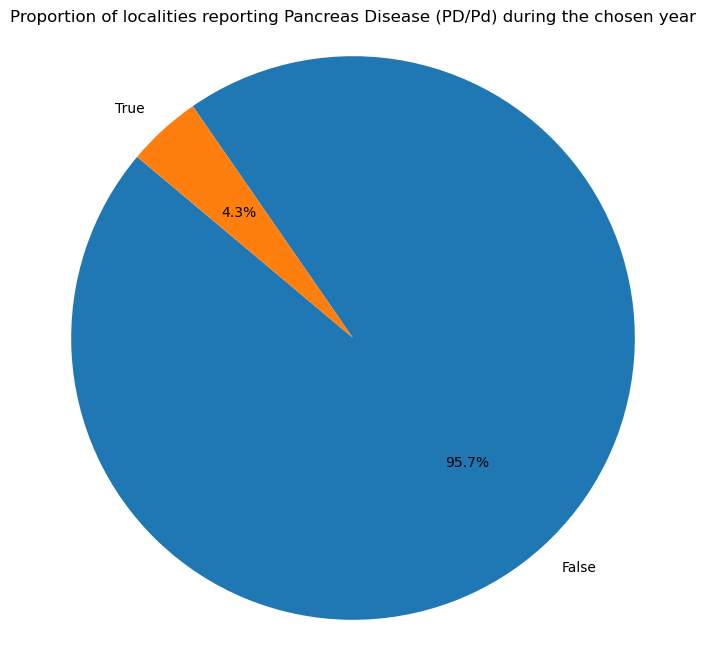

In [35]:
# Count the occurrences of True and False in the 'haspd' column
has_pd_counts = df_fish['haspd'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(has_pd_counts, labels=['False', 'True'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of localities reporting Pancreas Disease (PD/Pd) during the chosen year')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

<Axes: xlabel='year_week'>

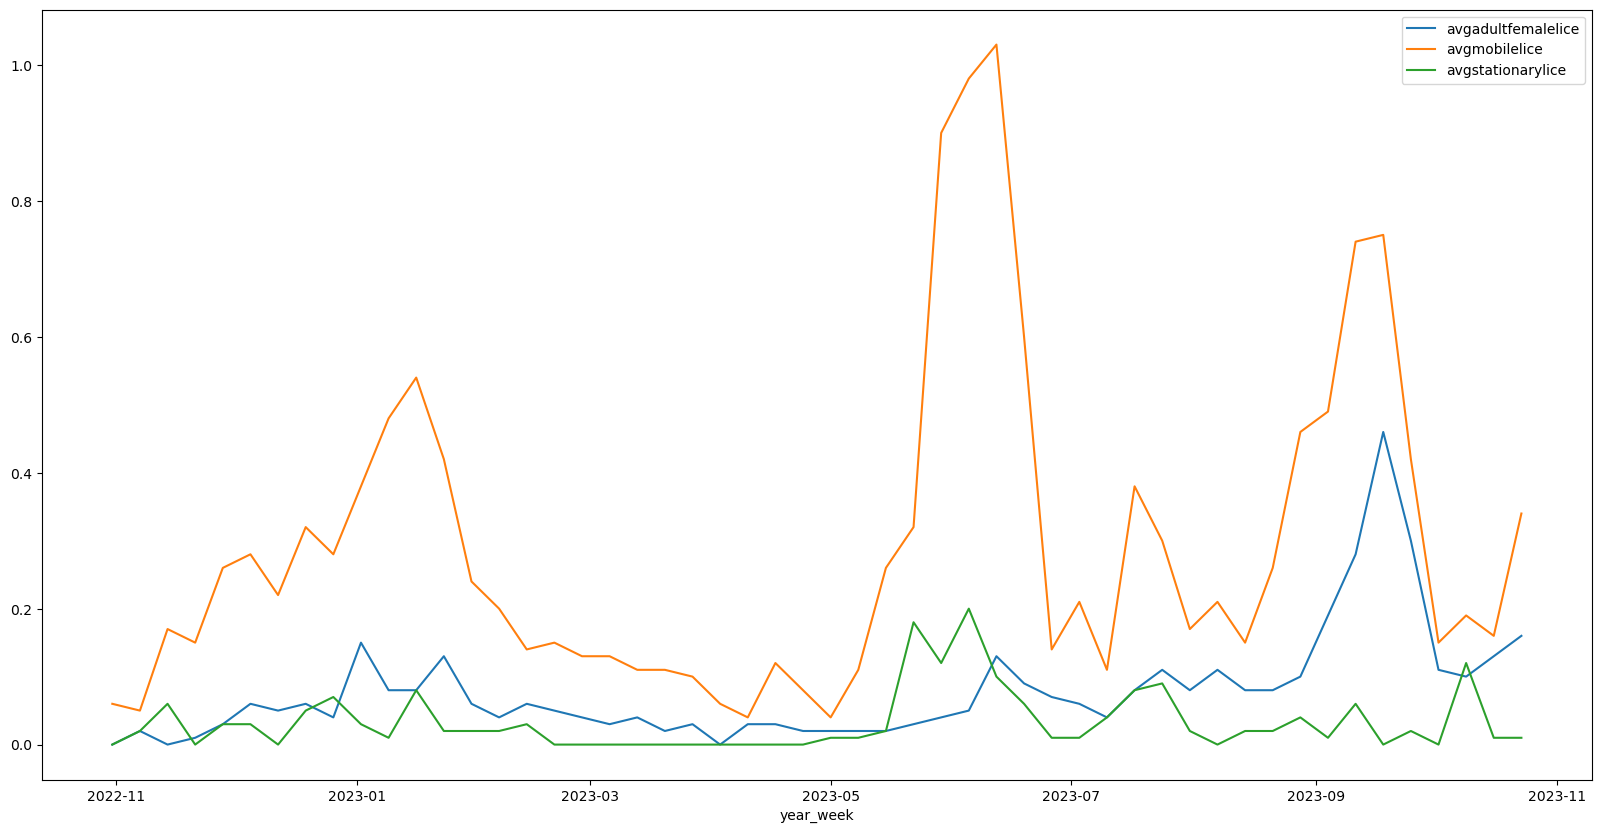

In [36]:
# Plot avgAdultFemaleLice, avgMobileLice, avgStationaryLice as a function of time
lice_counts.plot(x='year_week', y=['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'], figsize=(20,10))

<Axes: xlabel='year_week'>

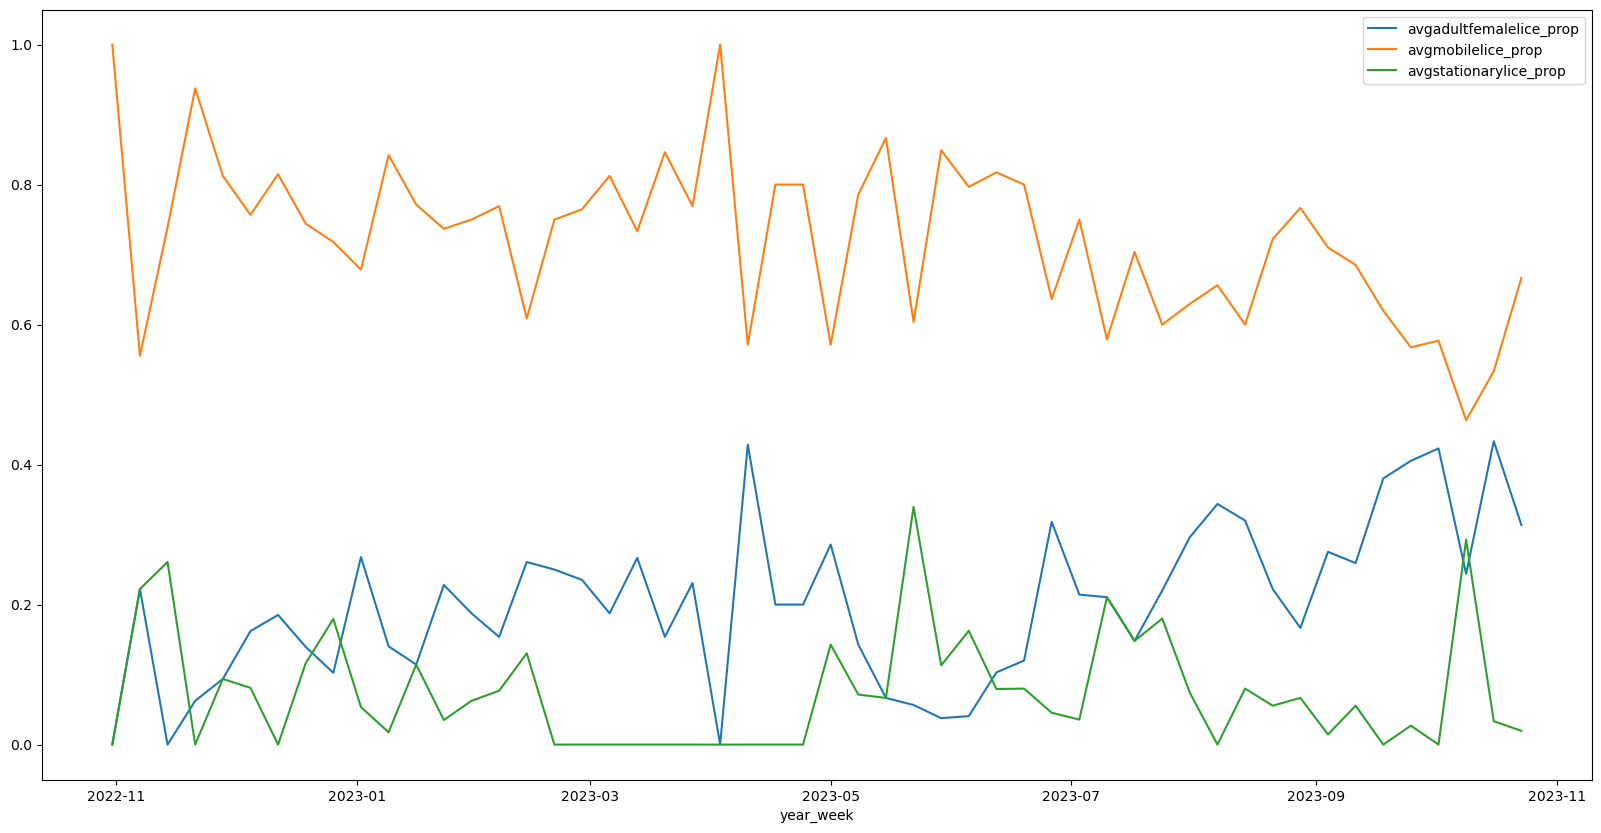

In [37]:
# Plot proportions of different lice types. include percentages in each time point
lice_counts['total_lice'] = lice_counts['avgadultfemalelice'] + lice_counts['avgmobilelice'] + lice_counts['avgstationarylice']
lice_counts['avgadultfemalelice_prop'] = lice_counts['avgadultfemalelice'] / lice_counts['total_lice']
lice_counts['avgmobilelice_prop'] = lice_counts['avgmobilelice'] / lice_counts['total_lice']
lice_counts['avgstationarylice_prop'] = lice_counts['avgstationarylice'] / lice_counts['total_lice']

lice_counts.plot(x='year_week', y=['avgadultfemalelice_prop', 'avgmobilelice_prop', 'avgstationarylice_prop'], figsize=(20, 10))
